# Xenium OSDR — Happy Path

This notebook runs a minimal, working OSDR analysis:
1) Load data
2) Score proliferation
3) Build `single_cell_df`
4) Run OSDR
5) Plot phase portrait + growth rate

Edit the data path and the two cell types below.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tdm.utils import microns
from tdm.preprocess.single_cell_df import check_single_cell_df
from tdm.analysis import Analysis
from tdm.plot.two_cells import plot_phase_portrait, plot_growth_rate
import matplotlib.pyplot as plt


In [ ]:
# 1) Load your data
ad = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust_with_scores_anno_comp.h5ad')


In [ ]:
# 2) Score proliferation markers (uses normalized/log data in ad.X)
prolif = [
    'Mki67','Top2a','Mcm2','Mcm3','Mcm4','Mcm5','Mcm6','Mcm7','Pcna','Tyms',
    'Cdk1','Ccna2','Ccnb1','Ccnb2','Cenpf','Aurka','Aurkb','Birc5','Ube2c'
]
present_prolif = [g for g in prolif if g in ad.var_names]
if len(present_prolif) == 0:
    raise ValueError('No proliferation markers found in ad.var_names')
sc.tl.score_genes(ad, present_prolif, score_name='prolif_score')


In [8]:
# 3) Build single_cell_df for OSDR
cell_type_col = 'anno_L2'

# Find x/y columns (edit if needed)
candidates = [
    ('x','y'),
    ('X','Y'),
    ('x_centroid','y_centroid'),
    ('X_centroid','Y_centroid'),
    ('centroid_x','centroid_y'),
]
x_col = y_col = None
for cx, cy in candidates:
    if cx in ad.obs.columns and cy in ad.obs.columns:
        x_col, y_col = cx, cy
        break
if x_col is None:
    raise ValueError('Could not find spatial columns. Set x_col/y_col manually.')

# IDs
img_id_col = 'fov_id' if 'fov_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)
subject_id_col = 'subject_id' if 'subject_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)

# Division: top 2% by prolif_score (adjust if needed)
division = ad.obs['prolif_score'] >= ad.obs['prolif_score'].quantile(0.98)

# Coordinates are assumed in microns
coords_in_microns = True
x_vals = ad.obs[x_col].astype(float)
y_vals = ad.obs[y_col].astype(float)
if coords_in_microns:
    x_vals = microns(x_vals)
    y_vals = microns(y_vals)

single_cell_df = pd.DataFrame({
    'x': x_vals,
    'y': y_vals,
    'cell_type': ad.obs[cell_type_col].astype(str),
    'division': division.astype(bool),
    'img_id': ad.obs[img_id_col].astype(str) if img_id_col else '1',
    'subject_id': ad.obs[subject_id_col].astype(str) if subject_id_col else '1',
})

check_single_cell_df(single_cell_df)


Validating single cell dataframe...

[SUCCESS] Found x column


                The spatial positions within the tissue should range from (0,0) to (x max, y max)
                
[SUCCESS] Found y column
[SUCCESS] Found cell_type column. Number of cell types: 21
	Cell types: ['Schwann cell', 'Artifact', 'Interneuron', 'Macrophage', 'Oligodendrocyte', 'Meningeal fibroblast', 'Microglia', 'Endothelial', 'Perineurial', 'T cell', 'Astrocyte', 'Monocyte-derived', 'Dendritic cell', 'OPC', 'Neuron', 'Pericyte', 'BAM', 'VSMC', 'B cell', 'Arachnoid barrier', 'Other']
[SUCCESS] Found division column. Fraction of dividing cells: 0.020
[SUCCESS] Found img_id column. Number of images found: 107
[SUCCESS] Found subject_id column. Number of subjects found: 107

[SUCCESS] Validation complete!


True

In [17]:
# 4) Choose two cell types to model
cell_types_to_model = [
    'T cell',
    'OPC',
]
allowed_neighbor_types = cell_types_to_model


In [18]:
# 5) Run OSDR (stable settings)
ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=cell_types_to_model,
    allowed_neighbor_types=allowed_neighbor_types,
    polynomial_dataset_kwargs={'degree': 1},
    neighborhood_mode='extrapolate',
    enforce_max_density=False,
    model_kwargs={'regularization_alpha': 1e-3},
)


1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


In [19]:
# Ensure custom cell types have display names/colors for plotting
from tdm.cell_types import CELL_TYPE_TO_FULL_NAME, CELL_FULL_NAME_TO_COLOR

for ct in cell_types_to_model:
    CELL_TYPE_TO_FULL_NAME.setdefault(ct, ct)
    if ct not in CELL_FULL_NAME_TO_COLOR:
        CELL_FULL_NAME_TO_COLOR[ct] = '#4C78A8'


/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


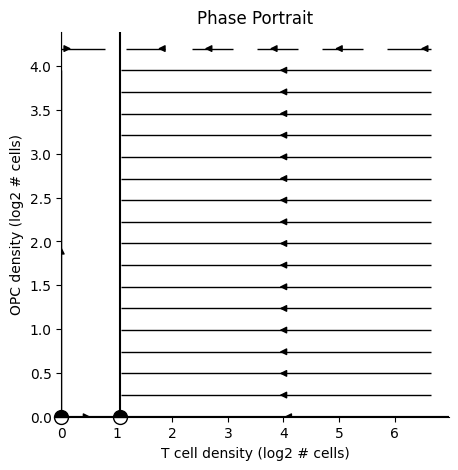

/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/tdm/plot/two_cells/phase_portrait.py:599: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/tdm/plot/two_cells/phase_portrait.py:599: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/

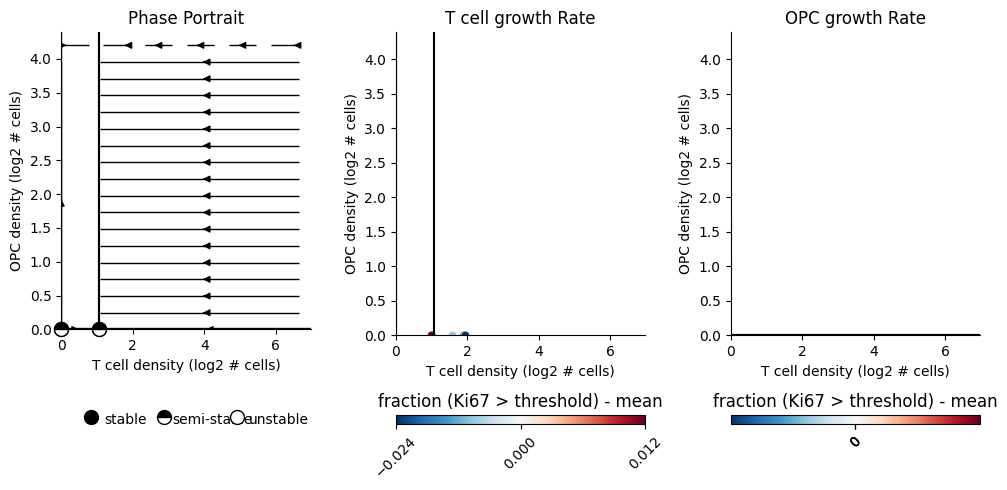

In [20]:
# 6) Plot phase portrait + growth rate
plot_phase_portrait(ana)
plt.show()

plot_growth_rate(ana)
plt.show()
